# Supratidal and Coastal Floodplain Forests (SCFF) time series notebook
#### This notebook is a demonstration of the current approach to mapping supratidal and coastal floodplain forests
#### In particular, this notebook demonstrates the capacity for running any given year in the Landsat time series
#### It is important to note that only the woody cover fraction dataset provides changes in extent as the supratidal extent model uses multi-year data (e.g. SRTM)
#### Data output from this notebook provide a three band output tif where
##### b1 = SCFF
##### b2 = confidence (values from 0-1) of an area being considered supratidal and coastal floodplain (SCF)
##### b3 = woody cover fraction (values from 0-1) within the area being considered supratidal and coastal floodplain

## User input
#### users need to select the tile of interest to run the code by selecting in the map display and input the id to the user inputs section
#### users need to select the output annual year between 1988-2023 and input the year to the user inputs section

Deliverables: To address these challenges for national mapping, as well as capacity for annual mapping, we will develop a workflow for supratidal forest extent mapping for any given year and publish on a GitHub repository. This will include detailed documentation in the repository for others to run the code and capacity for scalability to large areas (e.g. continental-scale analysis). This code with be published as open source under Apache 2.0 license as well as the output spatial datasets (under CC BY Attribution 4.0 International License), providing end users the capacity to utilise the code for generating a model of supratidal forest extent anywhere in Australia.

- user selects tile
- user selects drop down year
- code in loop is run extent model
- add in WCF to this
- spits out three images and exports 3 band tif
- make start instructions here aesthetic 


modularise
- tile HAT/SS stuff as py script
- make year a bit better as input that doubles currently

In [1]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

sys.path.insert(0, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map, map_shapefile
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
dc = datacube.Datacube()

# connectivity
sys.path.insert(1, "/home/jovyan/code/xarray-spatial")
from xrspatial.proximity import proximity

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

# tile file
vector_file = '../data/geojson/ga_summary_grid_c3_mainland_ext_v3.gpkg'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
gdf.explore(tooltip = 'id')

/env/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


## User inputs

In [2]:
# input the id of the tile of interest
tile_id = 280

# input the year
year = '2020'

# threshold to classify as forest for woody cover fraction data
forest_threshold = 0.4

## Run all code below

In [3]:
# add time (not a range, just repeat year input here)
time_range = (year, year)

In [4]:
mainland_grid = gdf[gdf['type'] == 'mainland']

In [5]:
HAT_path = '../data/HAT_MLP_Regression.gpkg'
HAT_gpd = gpd.read_file(HAT_path)
HAT_gpd_EPSG4326 = HAT_gpd.to_crs('EPSG:4326')

HAT_SS_path = '../data/STF_SS_ElevationClasses.geojson'
HAT_SS_gpd = gpd.read_file(HAT_SS_path)

In [6]:
# HAT
# Using sjoin to add mainland_grid to HAT values 
mainland_grid_HAT = gpd.sjoin(HAT_gpd_EPSG4326, mainland_grid, predicate='within')
# get maximum HAT value within coastal tile
max_values_HAT = mainland_grid_HAT.groupby('index_right')['HAT'].max()
# # append to new column
mainland_grid['HAT'] = max_values_HAT.astype(float)

# checking NaN values and replacing them with values from adjacent tiles ---NaN values in ID 52 (51) and 235 (234) will be replaced by nearby ID 53 (4.213) and ID 243 (1.904), respectively
# TODO: need to make this automated and not hardcoded as it is problematic with any changes in indexing #
mainland_grid.loc[mainland_grid['id'] == 52, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 65, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 235, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 243, 'HAT'].values[0]

# TODO: also adding in land locked tiles that don't have HAT to pull from, manually now adding froma adjacent tiles. This needs to be better
mainland_grid.loc[mainland_grid['id'] == 339, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 65, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 338, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 66, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 328, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 53, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 327, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 26, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 330, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 27, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 329, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 40, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 324, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 104, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 323, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 105, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 326, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 82, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 325, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 69, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 335, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 312, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 334, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 313, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 337, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 302, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 336, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 303, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 332, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 286, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 331, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 270, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 333, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 210, 'HAT'].values[0]


# additional tiles added by Raf for v2
mainland_grid.loc[mainland_grid['id'] == 340, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 191, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 341, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 89, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 342, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 67, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 343, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 67, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 344, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 260, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 345, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == , 'HAT'].values[0] # tile touching ocean
# mainland_grid.loc[mainland_grid['id'] == 346, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == , 'HAT'].values[0] # tile touching ocean
mainland_grid.loc[mainland_grid['id'] == 347, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 106, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 348, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 269, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 349, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 279, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 350, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 324, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 351, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 222, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 352, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == , 'HAT'].values[0] # tile touching ocean
mainland_grid.loc[mainland_grid['id'] == 353, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 186, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 354, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 338, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 355, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 67, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 356, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == , 'HAT'].values[0] # tile touching ocean

# additional tiles added by Raf for v3 (all tiles touching ocean except ID 371)
# mainland_grid.loc[mainland_grid['id'] == 357, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 20, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 358, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 19, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 359, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 314, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 360, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 90, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 361, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 32, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 362, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 298, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 363, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 298, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 364, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 277, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 365, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 12, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 366, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 41, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 367, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 31, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 368, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 249, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 369, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 238, 'HAT'].values[0]
# mainland_grid.loc[mainland_grid['id'] == 370, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 12, 'HAT'].values[0]
mainland_grid.loc[mainland_grid['id'] == 371, 'HAT'] = mainland_grid.loc[mainland_grid['id'] == 229, 'HAT'].values[0]


In [7]:
# HAT_SS
# Spatial join to find which geometries in gdf1 are within any polygon of gdf2
joined = gpd.sjoin(mainland_grid, HAT_SS_gpd, how = 'left', predicate='intersects')

# Dissolve duplicates the result based on the index
dissolved_joined = joined.dissolve(by=joined.index, aggfunc='first')

# Reset the index of the dissolved GeoDataFrame
dissolved_joined = dissolved_joined.reset_index(drop=True)

# Reset the index of mainland_grid to avoid duplicate index labels
mainland_grid = mainland_grid.reset_index(drop=True)

# add SS value
mainland_grid['SS'] = dissolved_joined['SSElev']
# generate new col for HAT+SS
mainland_grid['HAT_SS'] = mainland_grid['HAT'] + mainland_grid['SS']

In [8]:
# Function to buffer a geometry by a factor of two (for running proximity analysis on a greater area before cutting to tile size)
def double_buffer(geometry):
    return geometry.buffer(distance=0.5)  # Buffer by 0.5 to double the size

# Apply the double_buffer function to the geometry column
mainland_grid['doubled_geometry'] = mainland_grid['geometry'].apply(double_buffer)

In [9]:
id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
print(id_list)

[12, 13, 14, 15, 19, 20, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 100, 101, 102, 103, 104, 105, 106, 107, 108, 115, 116, 117, 125, 126, 136, 137, 138, 139, 140, 147, 148, 149, 150, 151, 152, 153, 158, 159, 160, 161, 162, 166, 167, 168, 169, 177, 178, 179, 180, 186, 187, 191, 192, 193, 196, 197, 198, 199, 201, 202, 203, 205, 206, 207, 208, 209, 210, 212, 213, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 277, 278, 279, 280, 281, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 306, 307, 309, 311, 312, 313, 31

In [10]:
mainland_grid_selection = mainland_grid.loc[(mainland_grid['id'] == tile_id)]
mainland_grid_selection
# TODO: need to looking to tiles that didnt run
# didn't run == 343 (arnem land), 348 (coorong), 354 (NT)
# land locked - maybe an issue of items not being present?

,region_code,ix,iy,utc_offset,id,type,geometry,HAT,SS,HAT_SS,doubled_geometry
183,x45y16,45,16,10,280,mainland,"POLYGON ((149.83826 -34.13579, 149.98501 -34.9...",1.100446,0.5,1.600446,"POLYGON ((149.77909 -33.63930, 150.81361 -33.5..."


In [11]:
mainland_grid_selection.explore()

In [12]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

query_buffered = {
    "time": time_range,
    'resolution':res}

In [13]:
# Loop through polygons in geodataframe and add geom to queries
sorted_mainland_grid_selection = mainland_grid_selection.sort_values(by='id')
total_rows = len(sorted_mainland_grid_selection)
count = 1

for index, row in sorted_mainland_grid_selection.iterrows():
    feature_id = row['id']
    print(f'Feature ID {feature_id}. Running {count}/{total_rows}')
    count += 1
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=mainland_grid_selection.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

    # Extract the feature's doubled geometry as a datacube geometry object
    geom = Geometry(geom=row.doubled_geometry, crs=gdf.crs)
    
    # Update the query to include our doubled geopolygon
    query_buffered.update({'geopolygon': geom})
    
    # Extracting specific keys from dictionary (removing time to load things like item and srtm)
    query_notime = {key: query[key] for key in query.keys()
           & {'resolution', 'geopolygon'}}
    query_buffered_notime = {key: query_buffered[key] for key in query_buffered.keys()
           & {'resolution', 'geopolygon'}}

    geometry = query_notime['geopolygon'].geom
    bbox = geometry.bounds   

    # need this to load streams (as gdf needs bounds)
    geometry = query_buffered_notime['geopolygon'].geom
    doubled_bbox = geometry.bounds    
    
    # Load datasets #
    # For supratidal elevation model, need srtm, wofs, mangroves, items loaded as tile area
    # For connectivity, need srtm, wofs, mangroves, item, saltmarsh, saltflat, streams load as buffered tile area
    # For connectivity, need srtm loaded as tile area for bounds to get back tile area only at the end
    
    # Load SRTM
    srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
    srtm = srtm_ds.dem_h
    # Load SRTM buffered
    srtm_ds_buffered = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_buffered_notime)
    srtm_buffered = srtm_ds_buffered.dem_h
    
    # Load in water from wofs
    wofs = dc.load(product="ga_ls_wo_fq_cyear_3", output_crs="EPSG:3577", measurements=["frequency"], **query)
    # get water class
    water = xr.where((wofs.frequency >= 0.2), 1, 0).astype('int8')
    # Load in water from wofs buffered
    wofs_buffered = dc.load(product="ga_ls_wo_fq_cyear_3", output_crs="EPSG:3577", measurements=["frequency"], **query_buffered)
    # get water class
    water_buffered = xr.where((wofs_buffered.frequency >= 0.2), 1, 0).astype('int8')
    
    # Load ITEMs
    item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
    # if no ITEMs within AOI, create dummy xr.dataarray
    if item_ds.data_vars == {}:
        item_ds = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
    else:
        item = item_ds.relative
    # Load ITEMs buffered
    item_ds_buffered = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_buffered_notime)
    # if no ITEMs buffered within AOI, create dummy xr.dataarray
    if item_ds_buffered.data_vars == {}:
        item_ds_buffered = xr.DataArray(np.zeros_like(srtm_buffered), coords=srtm_buffered.coords, dims=srtm_buffered.dims, attrs=srtm_buffered.attrs)
    else:
        item_buffered = item_ds_buffered.relative
    
    # Load in mangrove cover
    DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)
    # if no mangroves within AOI, create dummy xr.dataarray
    if DEAmangrove.data_vars == {}:
        mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
    else:
        # get output of mangrove == 1, not mangrove == 0
        mangrove = (DEAmangrove.canopy_cover_class != 255)
    # Load in mangrove cover buffered
    DEAmangrove_buffered = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query_buffered)
    # if no mangroves within AOI, create dummy xr.dataarray
    if DEAmangrove_buffered.data_vars == {}:
        mangrove_buffered = xr.DataArray(np.zeros_like(srtm_buffered), coords=srtm_buffered.coords, dims=srtm_buffered.dims, attrs=srtm_buffered.attrs)
    else:
        # get output of mangrove == 1, not mangrove == 0
        mangrove_buffered = (DEAmangrove_buffered.canopy_cover_class != 255)
    
    # Load in saltmarsh (buffered for connectivity, not use for elevation model)
    geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'
    # load in geotiff again but with identical extent from srtm
    saltmarsh = rio_slurp_xarray(geotiff_path, gbox=srtm_buffered.geobox)
    saltmarsh.attrs['crs'] = 'EPSG:3577'

    # Load in saltflat (buffered for connectivity, not use for elevation model)
    geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'
    # load in geotiff again but with identical extent from srtm
    saltflat = rio_slurp_xarray(geotiff_path, gbox=srtm_buffered.geobox)
    saltflat.attrs['crs'] = 'EPSG:3577'
    
    # Load in Geofabric mapped stream (buffered for connectivity, not use for elevation model)
    streams_gdf = gpd.read_file('/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/Geofabric/AHGFMappedStream.shp', bbox=doubled_bbox)
    # if no streams within AOI, create dummy xr.dataarray
    if streams_gdf.empty:
        streams_mask = xr.DataArray(np.zeros_like(srtm_buffered), coords=srtm_buffered.coords, dims=srtm_buffered.dims, attrs=srtm_buffered.attrs)
        streams_mask = streams_mask.squeeze('time')
    else:
        # get output of streams == 1, not streams == 0
        streams_mask = xr_rasterize(streams_gdf, srtm_ds_buffered)   
    
    
    # Threshold datasets as required #
    
    # elevation
    # greater than -6m AHD and less than 10m AHD == True
    # some areas in NT are below 0 AHD and need to be included in potential supratidal extent, hence value of -6 that Raf has checked is sensible.
    # for connectivity model less than 10m AHD == True (this needs to be thresholded as minimum at 0 for STF extent product due to supratidal areas not being below 0 AHD
    # in the original connectivity code a lower limit wasn't being used. see what outputs look like but might need to look into this closely
    AHD_min = -6
    AHD_max = 10
    lessthan_AHD = srtm <= AHD_max
    greaterthan_AHD = srtm >= AHD_min
    srtm_mask = lessthan_AHD & greaterthan_AHD
    # elevation buffered
    lessthan_AHD_buffered = srtm_buffered <= AHD_max
    greaterthan_AHD_buffered = srtm_buffered >= AHD_min
    srtm_mask_buffered = lessthan_AHD_buffered & greaterthan_AHD_buffered
    
    # srtm tile bounds (for connectivity)
    tile_mask = xr.DataArray(np.ones_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)

    # not water
    not_water = (1 - water)
    not_water = not_water == 1
    # note water buffered
    not_water_buffered = (1 - water_buffered)
    not_water_buffered = not_water_buffered == 1    
    
    # exposed intertidal
    intertidal = (item >= 2) & (item <= 8)
    # exposed intertidal buffered
    intertidal_buffered = (item_buffered >= 2) & (item_buffered <= 8)
    
    # not exposed intertidal == True
    not_intertidal = (1 - intertidal)
    # not exposed intertidal buffered == True
    not_intertidal_buffered = (1 - intertidal_buffered)
    
    # not mangrove == True
    not_mangrove = (1 - mangrove)
    not_mangrove = not_mangrove == 1
    # not mangrove buffered == True
    not_mangrove_buffered = (1 - mangrove_buffered)
    not_mangrove_buffered = not_mangrove_buffered == 1

    # Remove time dim on some variables #
    srtm_mask = srtm_mask.squeeze('time').astype('int8')
    srtm_mask_buffered = srtm_mask_buffered.squeeze('time').astype('int8')
    tile_mask = tile_mask.squeeze('time')
    water = water.squeeze('time')
    water_buffered = water_buffered.squeeze('time')
    not_water = not_water.squeeze('time')
    not_water_buffered = not_water_buffered.squeeze('time')
    intertidal = intertidal.squeeze('time')
    intertidal_buffered = intertidal_buffered.squeeze('time')
    not_intertidal = not_intertidal.squeeze('time')
    not_intertidal_buffered = not_intertidal_buffered.squeeze('time')
    mangrove = mangrove.squeeze('time')
    mangrove_buffered = mangrove_buffered.squeeze('time')
    not_mangrove = not_mangrove.squeeze('time')
    not_mangrove_buffered = not_mangrove_buffered.squeeze('time')

    
    # Connectivity model #
    
    # combine masks
    aquatic = xr.where((water_buffered == True) | (intertidal_buffered == True) | 
                       (mangrove_buffered == True) | (saltmarsh == True) | 
                       (saltflat == True) | (streams_mask == True), 1, 0).astype('int8')

    # xrspatial proximity - https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html
    # seems it is in same units as crs (EPSG3577 = metres)
    proximity_agg = proximity(aquatic)

    # mask with srtm_mask (need to do before normalisation so that min and max are within bounds of 0-10m elevation)
    proximity_agg_mask = proximity_agg.where(srtm_mask_buffered)


    # Find the minimum and maximum values in the data array - taking a percentile just to ensure any extreme odd values are not considered
    min_value = 0#np.nanpercentile(proximity_agg_mask, 0.01)
    max_value = 15000#np.nanpercentile(proximity_agg_mask, 99.99) # currently adding the reasonable max value we found in tiles across australia

    # Clip values above max_value percentile
    proximity_agg_mask = xr.where(proximity_agg_mask >= max_value, max_value, proximity_agg_mask.values)

    # Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
    proximity_norm = (proximity_agg_mask - min_value) / (max_value - min_value)

    # invert the normalisation to make connectivity layer output
    proximity_norm_invert = (1 - proximity_norm)

    # combine masks - removing water, mangroves and items from connectivity output
    # where its not mangrove or exposed intertidal
    combine_not_connectivity_masks = xr.where((not_water_buffered == True) & (not_intertidal_buffered == True) & (not_mangrove_buffered == True) , 1, np.nan)

    # remove areas that would not be supratidal forest connectivity (i.e. water bodies and mangroves to np.nan)
    supratidal_connectivity_buffered = proximity_norm_invert * combine_not_connectivity_masks    

    # select out connectivity area for bounds of original tile
    supratidal_connectivity = supratidal_connectivity_buffered * tile_mask
    
    
    # Elevation model (extent with HAT and storm surge probability) #

    # combine masks
    # where its not mangrove or exposed intertidal, but is within -6 to 10m AHD
    supratidal = xr.where((srtm_mask == True) & (not_water == True) & (not_intertidal == True) & (not_mangrove == True) , 1, 0).astype('int8')

    # Generate a polygon mask to keep only data within the polygon
    # mask = xr_rasterize(row, srtm_ds)

    # Mask dataset to set pixels outside the polygon to `NaN`
    supratidal_mask = supratidal

    # get elevation values for supratidal_mask
    supratidal_elev = srtm * supratidal_mask
    supratidal_elev = xr.where(supratidal_elev == 0, np.nan, supratidal_elev.values)


    # generate elevation probability product
    # values of 1 for <= HAT
    # values normalised between 1 and 0.5 > HAT and <= HAT_SS
    # values normalised between 0.5 and 1 > HAT_SS and <= 10m AHD
    HAT = xr.where(supratidal_elev <= row.HAT, 1, np.nan)

    # HAT + storm
    HAT_storm = xr.where((supratidal_elev > row.HAT) & (supratidal_elev <= row.HAT_SS), supratidal_elev.values, np.nan)

    # normalise between HAT and HAT_SS
    # Find the minimum and maximum values in the data array
    min_value = row.HAT
    max_value = row.HAT_SS
    # Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
    HAT_storm_norm = (HAT_storm - min_value) / (max_value - min_value)

    # invert the normalisation and normalise between 0.5 and 1
    HAT_storm_norm_05_1 = (((1 - HAT_storm_norm)/2) + 0.5)
    
    # HAT + storm to 10m
    HAT_storm_10AHD = xr.where((supratidal_elev > row.HAT_SS) & (supratidal_elev <= 10), supratidal_elev.values, np.nan)
    
    # normalise between HAT_SS and 10m AHD
    # Find the minimum and maximum values in the data array
    min_value = row.HAT_SS
    max_value = 10
    # Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
    HAT_storm_10AHD_norm = (HAT_storm_10AHD - min_value) / (max_value - min_value)

    # invert the normalisation and normalise between 0.5 and 1
    HAT_storm_10AHD_norm_05_0 = ((1 - HAT_storm_10AHD_norm)/2)
    
    # combine layers back together
    supratidal_combine = ((HAT.fillna(0)) + (HAT_storm_norm_05_1.fillna(0)) + (HAT_storm_10AHD_norm_05_0.fillna(0))).squeeze('time')
    # remove outside extent (make np.nan)
    supratidal_elevation_model = xr.where(supratidal_mask == 1, supratidal_combine.values, np.nan)
    
    
    # Generate supratidal and coastal floodplain extent model #
    # combine supratidal_connectivity and supratidal_elevation_model
    supratidal_extent_model = ((supratidal_connectivity + supratidal_elevation_model)/2)

    # Woody Cover Fraction model #

    # load in vp woody cover
    sys.path.insert(1, '../virtual_products') 
    # The dictionary which datacube uses to understand (resolve) the different virtual product functionality
    # Need to add any aggregations for the VP you're using

    # Get location of transformation
    aggregation = "best_pixel_gmad"
    agg_loc = importlib.import_module(aggregation)
    agg_class = aggregation.split('.')[-1]

    DEFAULT_RESOLVER.register('aggregate', agg_class, getattr(agg_loc, agg_class) )
    
    # Need to add any tranformations for the VP you're using
    # Get location of transformation
    transformation = "woody_cover"
    trans_loc = importlib.import_module(transformation)
    trans_class = transformation.split('.')[-1]

    DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )
    
    # load woody_cover vp
    product = catalog['woody_cover']
    woody_cover_vp = product.load(dc, **query)
    woody_cover = woody_cover_vp.woody_cover

    # # woody cover with threshold for saltmarsh
    woody_cover_threshold = xr.where(woody_cover_vp.woody_cover > forest_threshold, 1, np.nan)
    woody_cover_threshold.attrs['crs'] = 'EPSG:3577'
    
    
    

    # write_cog(geo_im=supratidal_connectivity,
    #           fname='/home/jovyan/gdata1/projects/coastal/supratidal_forests/outputs/SCF_connectivity_model_v1/' + 
    #           vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_SCF_connectivity_model_' + time_range[0] + '.tif', # first part gets AOI name
    #           overwrite=True,
    #           nodata=0.0)
    # write_cog(geo_im=supratidal_elevation_model,
    #           fname='/home/jovyan/gdata1/projects/coastal/supratidal_forests/outputs/SCF_elevation_model_v1/' + 
    #           vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_SCF_elevation_model_' + time_range[0] + '.tif', # first part gets AOI name
    #           overwrite=True,
    #           nodata=0.0)
    # write_cog(geo_im=supratidal_extent_model,
    #           fname='/home/jovyan/gdata1/projects/coastal/supratidal_forests/outputs/SCF_extent_model_v1/' + 
    #           vector_file.rsplit('/', 1)[-1].split('.')[0] + '_gridID_' + str(row['id']) +'_SCF_extent_model_' + time_range[0] + '.tif', # first part gets AOI name
    #           overwrite=True,
    #           nodata=0.0)

Feature ID 280. Running 1/1


In [14]:
# load in vp woody cover
sys.path.insert(1, '../virtual_products') 
# The dictionary which datacube uses to understand (resolve) the different virtual product functionality
# Need to add any aggregations for the VP you're using

# Get location of transformation
aggregation = "best_pixel_gmad"
agg_loc = importlib.import_module(aggregation)
agg_class = aggregation.split('.')[-1]

DEFAULT_RESOLVER.register('aggregate', agg_class, getattr(agg_loc, agg_class) )

In [15]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "woody_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [16]:
%%time
# load woody_cover vp
product = catalog['woody_cover']
woody_cover_vp = product.load(dc, **query)
woody_cover = woody_cover_vp.woody_cover

# # woody cover with threshold for saltmarsh
woody_cover_threshold = xr.where(woody_cover_vp.woody_cover > forest_threshold, 1, np.nan)
woody_cover_threshold.attrs['crs'] = 'EPSG:3577'

/env/lib/python3.10/site-packages/datacube/virtual/transformations.py:440: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  return time.astype('datetime64[Y]')
/env/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


CPU times: user 56.7 s, sys: 7.11 s, total: 1min 3s
Wall time: 1min 18s


In [17]:
# make mask so both outputs are same size
supratidal_extent_model_mask = xr.DataArray(np.ones_like(supratidal_extent_model), coords=supratidal_extent_model.coords, dims=supratidal_extent_model.dims)
woody_cover_mask = xr.DataArray(np.ones_like(woody_cover), coords=woody_cover.coords, dims=woody_cover.dims)
mask = supratidal_extent_model_mask * woody_cover_mask

supratidal_extent_model_masked = supratidal_extent_model * mask
woody_cover_masked = woody_cover * mask
woody_cover_threshold_masked = woody_cover_threshold * mask

In [18]:
# band 1 = supratidal and coastal floodplain forest 
# 0-1 values of extent model
# cut to WCF = 1

SCFF = xr.where(woody_cover_threshold_masked == 1, supratidal_extent_model_masked.values, np.nan)

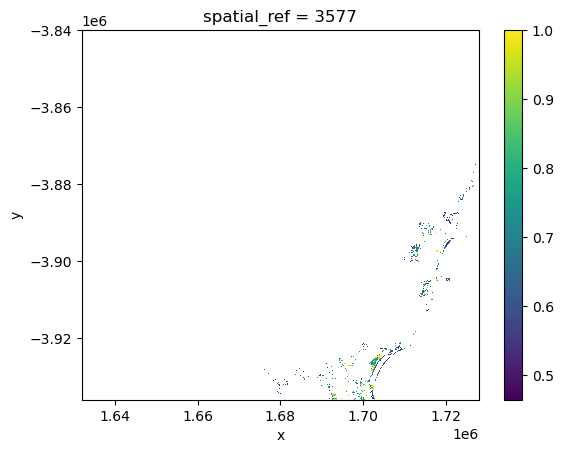

In [19]:
SCFF.plot()

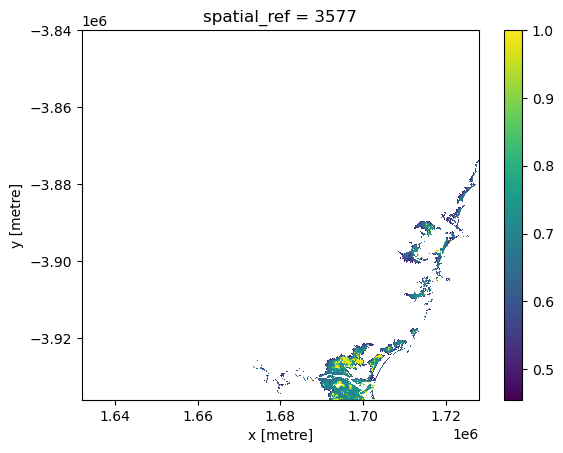

In [20]:
# band 2
# SCF extent
supratidal_extent_model_masked.plot()

In [21]:
# band 3 = woody cover fraction within SCF
# 0-1 values of WCF
# cut to SCF
WCF_SCF = xr.where(supratidal_extent_model_masked > 0, woody_cover_masked.values, np.nan)

In [22]:
# write_cog(geo_im=SCFF,
#           fname='SCFF.tif', # first part gets AOI name
#           overwrite=True,
#           nodata=0.0)

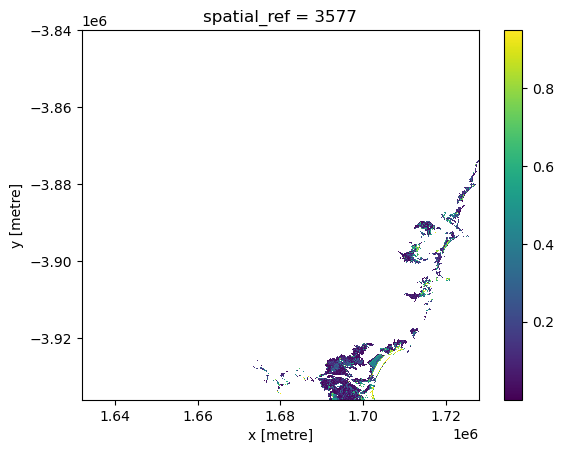

In [23]:
WCF_SCF.plot()